In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import syseng_throughputs as st
import rubin_sim.phot_utils as pt
from rubin_sim.data import get_data_dir

In [14]:
# Get the fiducial values
defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
print(defaultDirs)
atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
hardware, system = st.buildHardwareAndSystem(defaultDirs, addLosses=True, 
                                             atmosphereOverride=atmos, shiftFilters=None)
m5info = st.makeM5(hardware, system, X=1.0)

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/itl', 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1', 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2', 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3', 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters', 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}


In [15]:
m5info[['skyMag', 'skyCounts', 'Zp_t']]

,skyMag,skyCounts,Zp_t
u,23.051517,45.323056,26.524250
g,22.253795,463.653944,28.508377
r,21.197576,988.629815,28.360838
i,20.462781,1588.313329,28.171404
z,19.603265,2422.986877,27.797629
y,18.598127,2868.904463,26.874992


Text(0.5, 0, 'Wavelength (nm)')

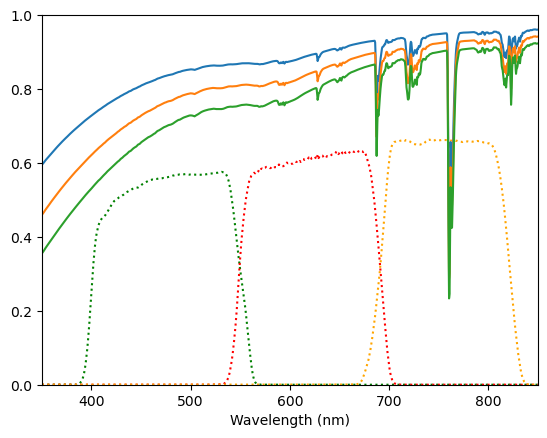

In [16]:
colors = {'g': 'g', 'r': 'r', 'i': 'orange'}
for f in 'gri':
    plt.plot(hardware[f].wavelen, hardware[f].sb, color=colors[f], linestyle=':')
for x in [1.0, 1.5, 2.0]:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    plt.plot(atmos.wavelen, atmos.sb, linestyle='-')
plt.ylim(0, 1)
plt.xlim(350, 850)
plt.xlabel("Wavelength (nm)")

In [18]:
defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

system = {}
for x in airmasses:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/itl', 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1', 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2', 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3', 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters', 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}


In [19]:
sky = pt.Sed()
sky.set_flat_sed()

phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)
phot_params_zp = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)

In [20]:
phot_params_test = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.7)
system[1.0]['r'].calc_zp_t(phot_params_test) - system[1.0]['r'].calc_zp_t(phot_params_zp)

-0.5761223034456862

In [21]:
phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)

zp = {}
for f in 'ugrizy':
    zp[f] = []
    for x in airmasses:
        zp[f].append(system[x][f].calc_zp_t(phot_params))
    zp[f] = np.array(zp[f])

In [22]:
exptimes = np.arange(1, 120.5, 1)
x = 1.0
zpt = {}
for f in 'ugrizy':
    zpt[f] = []
    for t in exptimes:
        phot_params = pt.PhotometricParameters(exptime=t, nexp=1, gain=1.0)
        zpt[f].append(system[x][f].calc_zp_t(phot_params))
    zpt[f] = np.array(zpt[f])

In [23]:
pd.DataFrame(zp, index=airmasses)

,u,g,r,i,z,y
1.0,26.524250,28.508377,28.360838,28.171404,27.797629,26.874992
1.1,26.477789,28.487304,28.348439,28.163573,27.791500,26.863698
1.2,26.431016,28.466118,28.335983,28.155781,27.785416,26.852698
1.3,26.385013,28.445235,28.323693,28.148152,27.779452,26.842165
1.4,26.338778,28.424268,28.311362,28.140555,27.773529,26.831859
1.5,26.292350,28.403230,28.298984,28.132992,27.767638,26.821759
1.6,26.246646,28.382481,28.286773,28.125554,27.761849,26.812036
1.7,26.199931,28.361320,28.274340,28.118057,27.756021,26.802321
1.8,26.153671,28.340360,28.262014,28.110643,27.750270,26.792878
1.9,26.109729,28.320317,28.250183,28.103519,27.744725,26.784006


In [24]:
from scipy import stats

slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((airmasses-1), zp[f])
slope, intercept

({'u': -0.45815223255080606,
  'g': -0.20789245761381037,
  'r': -0.12233512060667238,
  'i': -0.07387767800064417,
  'z': -0.05739100372986528,
  'y': -0.09474605376660676},
 {'u': 26.52231025834397,
  'g': 28.507547620761827,
  'r': 28.360365812523426,
  'i': 28.170380673108845,
  'z': 27.796728189989665,
  'y': 26.870922441512732})

In [25]:
from scipy import stats

slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((airmasses-1), zp[f])
slope, intercept

({'u': -0.45815223255080606,
  'g': -0.20789245761381037,
  'r': -0.12233512060667238,
  'i': -0.07387767800064417,
  'z': -0.05739100372986528,
  'y': -0.09474605376660676},
 {'u': 26.52231025834397,
  'g': 28.507547620761827,
  'r': 28.360365812523426,
  'i': 28.170380673108845,
  'z': 27.796728189989665,
  'y': 26.870922441512732})

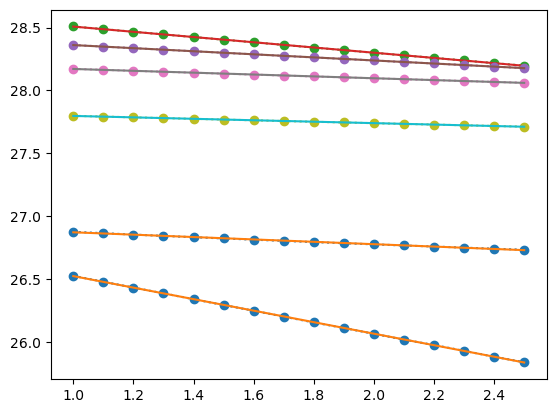

In [26]:
for f in 'ugrizy':
    plt.plot(airmasses, zp[f], marker='o', linestyle=':')
    plt.plot(airmasses, intercept[f] + slope[f] * (airmasses - 1))

In [27]:
slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((np.log10(exptimes)), zpt[f])

slope, intercept

({'u': 2.4999999999999987,
  'g': 2.499999999999998,
  'r': 2.5,
  'i': 2.4999999999999973,
  'z': 2.4999999999999987,
  'y': 2.5},
 {'u': 26.524249666113604,
  'g': 28.5083772093406,
  'r': 28.360838105835857,
  'i': 28.17140376815658,
  'z': 27.797628771787387,
  'y': 26.874992471661063})

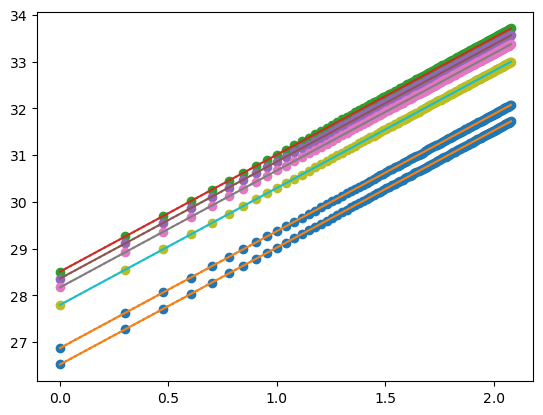

In [28]:
for f in 'ugrizy':
    plt.plot(np.log10(exptimes), zpt[f], marker='o', linestyle=':')
    plt.plot(np.log10(exptimes), intercept[f] + slope[f] * (np.log10(exptimes)))

In [29]:
dict(pd.DataFrame(zp, index=airmasses).loc[1.0])

{'u': 26.524249666113604,
 'g': 28.508377209340598,
 'r': 28.36083810583586,
 'i': 28.171403768156573,
 'z': 27.797628771787387,
 'y': 26.87499247166106}

In [30]:
def return_zeropoint(filtername: str, airmass: float, exptime: float=1) -> float:
    extinction_coeff = {'u': -0.45815823969467745,
                         'g': -0.20789273881603035,
                         'r': -0.12233514157672552,
                         'i': -0.07387773563152214,
                         'z': -0.0573260392897174,
                         'y': -0.09549137502152871}
    zeropoint_X1 = {'u': 26.524236651926522,
                    'g': 28.508375123264223,
                     'r': 28.36083779622462,
                     'i': 28.17139616900105,
                     'z': 27.78226401325628,
                     'y': 26.817818872890957}
    
    return zeropoint_X1[filtername] + extinction_coeff[filtername] * (airmass - 1) + 2.5 * np.log10(exptime)

def return_zeropoint_itl(filtername: str, airmass: float, exptime: float=1) -> float:
    extinction_coeff = {'u': -0.45815223255080606,
                        'g': -0.20789245761381037,
                        'r': -0.12233512060667238,
                        'i': -0.07387767800064417,
                        'z': -0.05739100372986528,
                        'y': -0.09474605376660676}
    zeropoint_X1 = {'u': 26.524249666113604,
                    'g': 28.508377209340598,
                    'r': 28.36083810583586,
                    'i': 28.171403768156573,
                    'z': 27.797628771787387,
                    'y': 26.87499247166106}
    
    return zeropoint_X1[filtername] + extinction_coeff[filtername] * (airmass - 1) + 2.5 * np.log10(exptime)

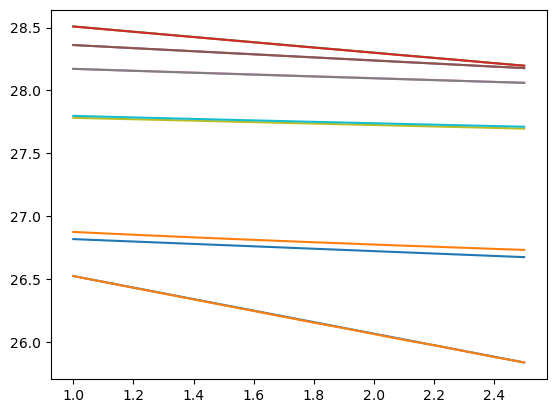

In [32]:
for f in 'ugrizy':
    y = return_zeropoint(f, airmasses)
    plt.plot(airmasses, y)
    plt.plot(airmasses, zp[f])

In [33]:
# Hardware only 
phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)
exptimes = np.arange(1, 120.5, 1)
x = 1.0
zpt = {}
for f in 'ugrizy':
    zpt[f] = []
    for t in exptimes:
        phot_params = pt.PhotometricParameters(exptime=t, nexp=1, gain=1.0)
        zpt[f].append(hardware[f].calc_zp_t(phot_params))
    zpt[f] = np.array(zpt[f])

In [41]:
for f in 'ugrizy':
    print(f"'{f}': {zp[f][0]},")

'u': 26.524249666113604,
'g': 28.508377209340598,
'r': 28.36083810583586,
'i': 28.171403768156573,
'z': 27.797628771787387,
'y': 26.87499247166106,


In [42]:
# Hardware only is appropriate for skybrightness. The location on the sky is included in the *generation* of the value.
def return_zeropoint_hardware(filtername: str, exptime: float=1) -> float:
    zeropoint = {'u': 26.99435242519598,
                 'g': 28.72132437054738,
                'r': 28.487206668180864,
                'i': 28.267160381353793,
                'z': 27.850681356053688,
                'y': 26.988827459758397}
    return zeropoint[filtername] + 2.5 * np.log10(exptime)

def return_zeropoint_hardware_itl(filtername: str, exptime: float=1) -> float:
    zeropoint = { 'u': 26.524249666113604,
                 'g': 28.508377209340598,
                 'r': 28.36083810583586,
                 'i': 28.171403768156573,
                 'z': 27.797628771787387,
                 'y': 26.87499247166106}
    return zeropoint[filtername] + 2.5 * np.log10(exptime)

In [45]:
zp = return_zeropoint_hardware('i', 30)
mag = 20.463
platescale = phot_params.platescale
np.power(10, (mag-zp)/-2.5) * platescale**2

1587.981353754498

In [43]:
platescale

0.2